## Skin Cancer Classification Transfer Learning ResNet50

In [1]:
import sys
print(sys.executable)

/home/blaise/anaconda3/envs/py310/bin/python


In [4]:
!pip install pandas numpy matplotlib opencv-python scikit-learn seaborn

In [5]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import sklearn

### Creating Dataset

In [ ]:
# os.mkdir("HAM_Dataset")
# base = "HAM_Dataset"

# os.mkdir(os.path.join(base, "MEL"))
# os.mkdir(os.path.join(base, "NV"))
# os.mkdir(os.path.join(base, "BCC"))
# os.mkdir(os.path.join(base, "AKIEC"))
# os.mkdir(os.path.join(base, "BKL"))
# os.mkdir(os.path.join(base, "DF"))
# os.mkdir(os.path.join(base, "VASC"))

# print(os.listdir(base))

In [6]:
for image in os.listdir('HAM_images'):
  if "jpg" not in image:
    os.remove('HAM_images/'+image)

for image in os.listdir('HAM_images'):
  if "jpg" not in image:
    print(image)

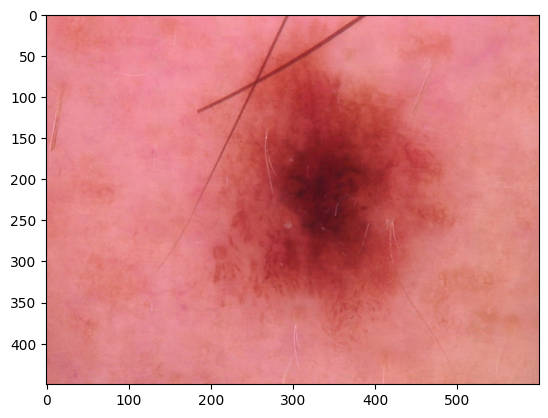

(450, 600, 3)


In [7]:
img = os.listdir('HAM_images')[0]
skin=cv2.imread('HAM_images/'+img)
plt.imshow(cv2.cvtColor(skin, cv2.COLOR_BGR2RGB))
plt.show()

print(skin.shape)

In [8]:
mapping = {
    "MEL": 1,
    "NV": 2,
    "BCC": 3,
    "AKIEC": 4,
    "BKL": 5,
    "DF": 6,
    "VASC": 7
}

df_labels = pd.read_csv("HAM10000_metadata.csv")
newData = pd.DataFrame(columns=["image","MEL","NV","BCC","AKIEC","BKL","DF","VASC","label"])
for i in range(len(df_labels)):
    tempy = [0,0,0,0,0,0,0,0,0]
    tempy[0] = df_labels.iloc[i]["image_id"]
    tempy[-1] = df_labels.iloc[i]["dx"].upper()
    tempy[mapping[df_labels.iloc[i]["dx"].upper()]] = 1.0
    newData.loc[len(newData)] = tempy

df_labels.head(),newData

(     lesion_id      image_id   dx dx_type   age   sex localization
 0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
 1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
 2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
 3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
 4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear,
               image  MEL   NV  BCC  AKIEC  BKL   DF  VASC  label
 0      ISIC_0027419  0.0  0.0  0.0    0.0  1.0  0.0   0.0    BKL
 1      ISIC_0025030  0.0  0.0  0.0    0.0  1.0  0.0   0.0    BKL
 2      ISIC_0026769  0.0  0.0  0.0    0.0  1.0  0.0   0.0    BKL
 3      ISIC_0025661  0.0  0.0  0.0    0.0  1.0  0.0   0.0    BKL
 4      ISIC_0031633  0.0  0.0  0.0    0.0  1.0  0.0   0.0    BKL
 ...             ...  ...  ...  ...    ...  ...  ...   ...    ...
 10010  ISIC_0033084  0.0  0.0  0.0    1.0  0.0  0.0   0.0  AKIEC
 10011  ISIC_0033550  0.0  0.0  0.0    1.0  0.0  0.0   0.0  AKI

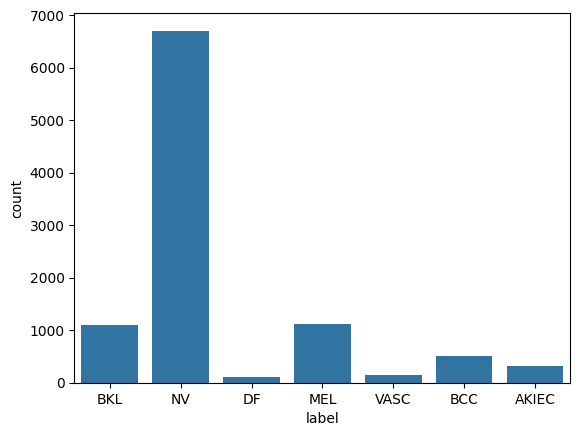

In [9]:
sns.countplot(x="label",data=newData)
plt.show()

In [10]:
from sklearn.utils import class_weight
import numpy as np

class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.array(['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']),
                                                  y=newData["label"])
class_wt_dict=dict(enumerate(class_weights))
class_wt_dict

{0: 4.375273044997815,
 1: 2.78349082823791,
 2: 1.301832835044846,
 3: 12.440993788819876,
 4: 1.2854575792581184,
 5: 0.21338020666879728,
 6: 10.075452716297788}

In [ ]:
# from tqdm import tqdm

# images = os.listdir('HAM_images')

# for image in tqdm(images):
#     fname=image[:-4]
#     label=list(newData[newData.image == fname]["label"])[0]
#     src = os.path.join('HAM_images', image)
#     dst = os.path.join('HAM_Dataset', label, image)
#     shutil.copyfile(src,dst)

### Train Test Split

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import preprocess_input as base_preprocess


image_gen = ImageDataGenerator(
                               preprocessing_function=base_preprocess,
                               rotation_range=30,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.1,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               fill_mode='nearest',
                               # rescale=1/255,
                               validation_split=0.15)

In [13]:
data_dir = 'HAM_Dataset'
batch_size = 64
target_size = (224,224)
train_image_gen = image_gen.flow_from_directory(data_dir, 
                                          target_size=target_size,
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          subset="training")

test_image_gen = image_gen.flow_from_directory(data_dir, 
                                          target_size=target_size, 
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          shuffle=False,
                                          subset="validation")

print(test_image_gen.class_indices)

Found 8516 images belonging to 7 classes.
Found 1499 images belonging to 7 classes.
{'AKIEC': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'VASC': 6}


<Axes: ylabel='count'>

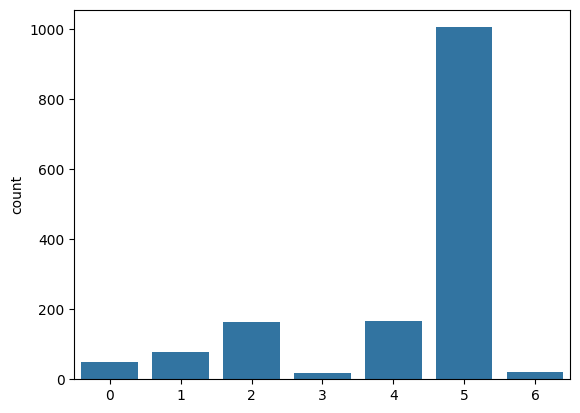

In [14]:
sns.countplot(x=test_image_gen.classes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-113.70528..119.07305].


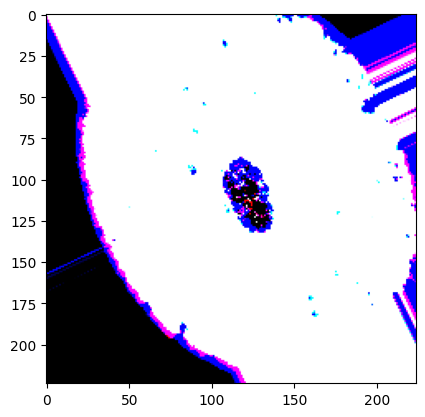

In [15]:
plt.imshow(train_image_gen[0][0][0])

##     

## Transfer Learning using ResNet50 Model

In [16]:
from tensorflow.keras.applications import *
from tensorflow.keras.layers import Flatten, Dense, Input, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
#x = Flatten()(x)
# x = Dense(4096, activation='relu')(x)
# x = Dropout(0.5)(x)
# x = Dense(512, activation='relu')(x)
# x = Dropout(0.5)(x)
x = Dense(256,kernel_regularizer='l2',activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(7, activation='softmax')(x)
tl_model = Model(inputs=base_model.input, outputs=x)


tl_model.summary()

I0000 00:00:1728996446.018367    5703 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728996446.546348    5703 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728996446.546417    5703 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728996446.549051    5703 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728996446.549105    5703 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,114,055 (91.99 MB)

 Trainable params: 24,060,935 (91.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [17]:
optimizer = Adam(0.0001)
tl_model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

## Model Training

In [18]:
!pip install tensorflow

In [2]:
import tensorflow as tf

# Check if GPUs are available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Using GPU: {gpus}")

    # Limit GPU memory usage to 12 GB
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]  # 12 GB in MB
        )
        print("Successfully set GPU memory limit to 12 GB.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found. Using CPU.")

Using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Successfully set GPU memory limit to 12 GB.


In [20]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2,mode='max', min_lr=0.00001,verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=2, verbose=1)
model_chkpt = ModelCheckpoint('test_gpu.keras',save_best_only=True, monitor='val_accuracy',verbose=1)

callback_list = [model_chkpt,lr_reduce]

In [21]:
with tf.device('/GPU:0'):
    history = tl_model.fit(train_image_gen,
                        epochs=15, 
                        validation_data = test_image_gen,
                        # class_weight=class_wt_dict)
                        callbacks=callback_list)

/home/blaise/anaconda3/envs/py310/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


I0000 00:00:1728996514.209267    5859 service.cc:146] XLA service 0x7f4d38006c80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728996514.209325    5859 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-10-15 12:48:35.015331: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-15 12:48:38.210710: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-10-15 12:48:41.629575: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_15494', 176 bytes spill stores, 468 bytes spill loads

2024-10-15 12:48:43.559873: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in fun

  8/134 ━━━━━━━━━━━━━━━━━━━━ 2:39 1s/step - accuracy: 0.3410 - loss: 6.5288

2024-10-15 12:49:28.395580: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_17354', 8 bytes spill stores, 8 bytes spill loads

2024-10-15 12:49:50.164100: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_48', 176 bytes spill stores, 176 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion', 44 bytes spill stores, 44 bytes spill loads



134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6466 - loss: 5.4261

2024-10-15 12:53:09.793860: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1720', 28 bytes spill stores, 28 bytes spill loads

2024-10-15 12:53:10.705887: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1720', 176 bytes spill stores, 176 bytes spill loads




Epoch 1: val_accuracy improved from -inf to 0.73115, saving model to test_gpu.keras
134/134 ━━━━━━━━━━━━━━━━━━━━ 303s 2s/step - accuracy: 0.6472 - loss: 5.4228 - val_accuracy: 0.7312 - val_loss: 4.8005 - learning_rate: 1.0000e-04
Epoch 2/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8061 - loss: 4.1232
Epoch 2: val_accuracy improved from 0.73115 to 0.81454, saving model to test_gpu.keras
134/134 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.8061 - loss: 4.1218 - val_accuracy: 0.8145 - val_loss: 3.5982 - learning_rate: 1.0000e-04
Epoch 3/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8455 - loss: 3.3232
Epoch 3: val_accuracy improved from 0.81454 to 0.84990, saving model to test_gpu.keras
134/134 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.8455 - loss: 3.3220 - val_accuracy: 0.8499 - val_loss: 2.8676 - learning_rate: 1.0000e-04
Epoch 4/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8720 - loss: 2.6695
Epoch 4: val_accuracy did not improve from 0.849

### Model Evaluation

In [22]:
df=pd.DataFrame(tl_model.history.history)
df.to_csv('hist.csv')

<Axes: >

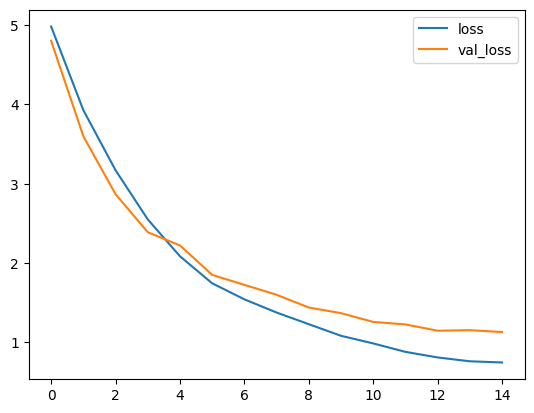

In [23]:
metrics = pd.DataFrame(tl_model.history.history)
metrics[["loss","val_loss"]].plot()

<Axes: >

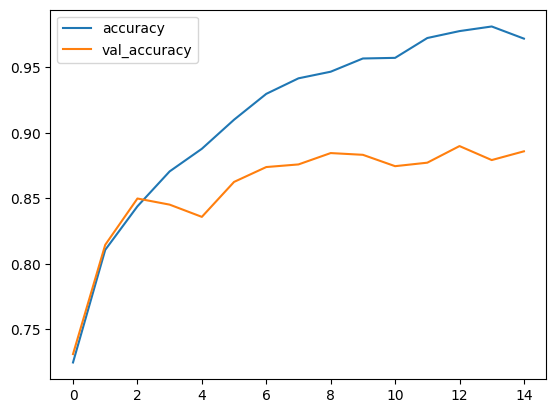

In [24]:
metrics[["accuracy","val_accuracy"]].plot()

In [25]:
tl_model.evaluate(test_image_gen)

24/24 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.7921 - loss: 1.4864


[1.119695782661438, 0.8805870413780212]

In [26]:
predictions = tl_model.predict(test_image_gen, verbose=1)
predictions = predictions.argmax(axis=1)

test_labels = test_image_gen.classes

24/24 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step 


In [27]:
import sklearn
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(test_labels, predictions)

Normalized confusion matrix


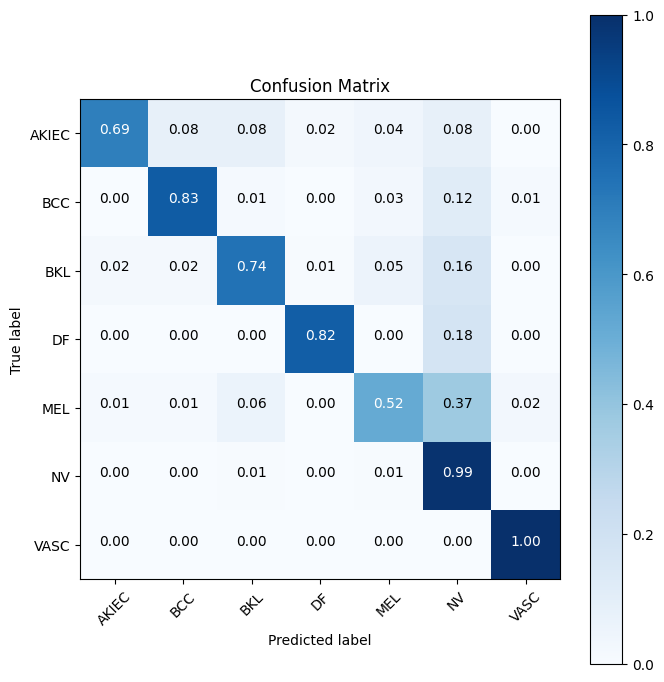

In [28]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


cm_plot_labels = list(test_image_gen.class_indices.keys())
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix', normalize=True)

In [29]:
print(classification_report(test_image_gen.classes, predictions, zero_division=0))

              precision    recall  f1-score   support

           0       0.87      0.69      0.77        49
           1       0.88      0.83      0.85        77
           2       0.85      0.74      0.79       164
           3       0.88      0.82      0.85        17
           4       0.82      0.52      0.63       166
           5       0.91      0.99      0.94      1005
           6       0.81      1.00      0.89        21

    accuracy                           0.89      1499
   macro avg       0.86      0.80      0.82      1499
weighted avg       0.89      0.89      0.88      1499

